## SEA-POL QVP data

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import glob
import os

In [ ]:
# Load data
file_dirs = glob.glob("/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_volume/202408*")

# loop through directories
for file_dir in file_dirs:
    # get the date from the directory name
    date = os.path.basename(file_dir)
    print(f"Processing data for {date}")

    file_paths = glob.glob(file_dir+"/*.nc")
    qvp = xr.open_mfdataset(file_paths, combine='by_coords')

    # Mask the data
    # missing data (blocking sectors)
    #rainrate = qvp.RATE_CSU_BLENDED.where(qvp.RATE_CSU_BLENDED >=-30000, np.nan)
    dbz = qvp.DBZ.where(qvp.DBZ >=-30000, np.nan)

    #change -9999 missing data to zeros for rain, NaN for DBZ
    #rainrate2 = rainrate.where(rainrate != -9999, 0)
    dbz2 = dbz.where(dbz != -9999, np.nan)

    # Average spatially at each level (results in time x height)
    #rainrate_avg = rainrate2.mean(dim=['X', 'Y'],skipna=True)
    dbz_avg = dbz2.mean(dim=['X', 'Y'],skipna=True) 
    #rainrate_cond = rainrate2.where(rainrate2>0).mean(dim=('X','Y'),skipna=True)

    # Save to netcdf file
    #rainrate_avg.attrs['units'] = 'mm/h'
    #rainrate_cond.attrs['units'] = 'mm/h'
    dbz_avg.attrs['units'] = 'dBZ'

    #combine into one dataset
    #qvp1D= xr.Dataset({'rainrate_avg': rainrate_avg, 'dbz_avg': dbz_avg, 'rainrate_int': rainrate_cond})
    qvp1D= xr.Dataset({'dbz_avg': dbz_avg})

    #add attributes
    qvp1D.attrs['title'] = 'Average rain rate and reflectivity at each altitude from SEA-POL QVP'
    qvp1D.attrs['description'] = 'Spatial means of rainrate from SEA-POL 45 degree elevation scans at different altitudes. Mean is the average over all valid data points (including zeros). Int (intensity) is the average over all data points where rainrate > 0.'
    qvp1D.attrs['source'] = 'SEA-POL Level4a QVP Volume'

    #save to netcdf
    qvp1D.to_netcdf('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_1D/qvp_'+date+'.nc', mode='w', format='NETCDF4')


Processing data for 20240824
Processing data for 20240816
Processing data for 20240823
Processing data for 20240829
Processing data for 20240830
Processing data for 20240827
Processing data for 20240818


In [3]:
# Load data
file_paths = glob.glob("/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_volume/20240908/*.nc")

#Open the files and combine them into a single dataset
qvp = xr.open_mfdataset(file_paths,combine='by_coords')

In [4]:
qvp

<xarray.Dataset> Size: 150GB
Dimensions:           (time: 144, Z: 181, Y: 361, X: 361)
Coordinates:
  * time              (time) datetime64[ns] 1kB 2024-09-08T00:06:14.868999936...
  * X                 (X) float32 1kB -1.8e+04 -1.79e+04 ... 1.79e+04 1.8e+04
  * Y                 (Y) float32 1kB -1.8e+04 -1.79e+04 ... 1.79e+04 1.8e+04
  * Z                 (Z) float32 724B 0.0 100.0 200.0 ... 1.79e+04 1.8e+04
    latitude          (time, Y, X) float32 75MB dask.array<chunksize=(1, 361, 361), meta=np.ndarray>
    longitude         (time, Y, X) float32 75MB dask.array<chunksize=(1, 361, 361), meta=np.ndarray>
Data variables: (12/15)
    start_time        (time) datetime64[ns] 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    stop_time         (time) datetime64[ns] 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    grid_mapping      (time) int32 576B -32768 -32768 -32768 ... -32768 -32768
    heading           (time) float32 576B dask.array<chunksize=(1,), meta=np.ndarray>
    DBZ               (time, Z, Y, X) float32 14GB dask.array<chunksize=(1, 181, 361, 361), meta=np.ndarray>
    RATE_CSU_BLENDED  (time, Z, Y, X) float32 14GB dask.array<chunksize=(1, 181, 361, 361), meta=np.ndarray>
    ...                ...
    SQI               (time, Z, Y, X) float32 14GB dask.array<chunksize=(1, 181, 361, 361), meta=np.ndarray>
    HID_CSU           (time, Z, Y, X) float32 14GB dask.array<chunksize=(1, 181, 361, 361), meta=np.ndarray>
    WIDTH             (time, Z, Y, X) float32 14GB dask.array<chunksize=(1, 181, 361, 361), meta=np.ndarray>
    KDP               (time, Z, Y, X) float32 14GB dask.array<chunksize=(1, 181, 361, 361), meta=np.ndarray>
    VEL               (time, Z, Y, X) float32 14GB dask.array<chunksize=(1, 181, 361, 361), meta=np.ndarray>
    PID_FOR_QC        (time, Z, Y, X) float32 14GB dask.array<chunksize=(1, 181, 361, 361), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by Michael M. Bell using custom software
    institution:  CSU
    source:       SEAPOL
    title:        PRELIMINARY Gridded Radar Data
    comment:      PRELIMINARY In-field Analysis. Please use with caution!

In [9]:
# Mask the data
# missing data (blocking sectors)
rainrate = qvp.RATE_CSU_BLENDED.where(qvp.RATE_CSU_BLENDED >=-30000, np.nan)
dbz = qvp.DBZ.where(qvp.DBZ >=-30000, np.nan)

#change -9999 missing data to zeros for rain, NaN for DBZ
rainrate2 = rainrate.where(rainrate != -9999, 0)
dbz2 = dbz.where(dbz != -9999, np.nan)

In [26]:
# Average spatially at each level (results in time x height)
rainrate_avg = rainrate2.mean(dim=['X', 'Y'],skipna=True)
dbz_avg = dbz2.mean(dim=['X', 'Y'],skipna=True)
dbz_avg

<xarray.DataArray 'DBZ' (time: 144, Z: 181)> Size: 104kB
dask.array<mean_agg-aggregate, shape=(144, 181), dtype=float32, chunksize=(1, 181), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1kB 2024-09-08T00:06:14.868999936 ... 2024...
  * Z        (Z) float32 724B 0.0 100.0 200.0 ... 1.78e+04 1.79e+04 1.8e+04

In [27]:
dbz_avg.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(144, 181), dtype=float32)

/tmp/ipykernel_2142853/4270886646.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_2142853/4270886646.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -2.5, '−2.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 5.0, '5.0'),
 Text(0, 7.5, '7.5'),
 Text(0, 10.0, '10.0'),
 Text(0, 12.5, '12.5'),
 Text(0, 15.0, '15.0'),
 Text(0, 17.5, '17.5'),
 Text(0, 20.0, '20.0')]

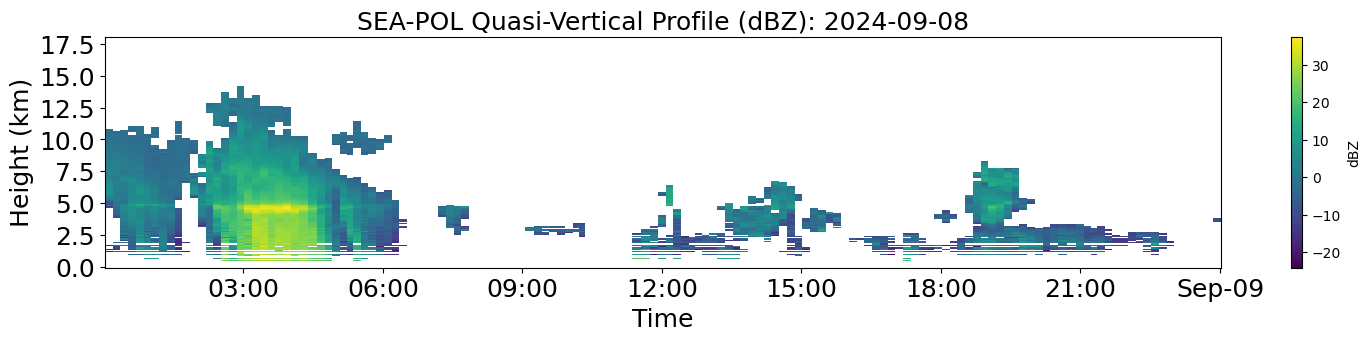

In [34]:
#plot
fig,ax = plt.subplots(figsize=(18,3))
plt.pcolormesh(dbz_avg.time, dbz_avg.Z/1000, dbz_avg.transpose(), cmap='viridis', shading='auto')
plt.colorbar(label='dBZ')

ax.set_title('SEA-POL Quasi-Vertical Profile (dBZ): 2024-09-08',fontsize=18)   
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel('Height (km)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

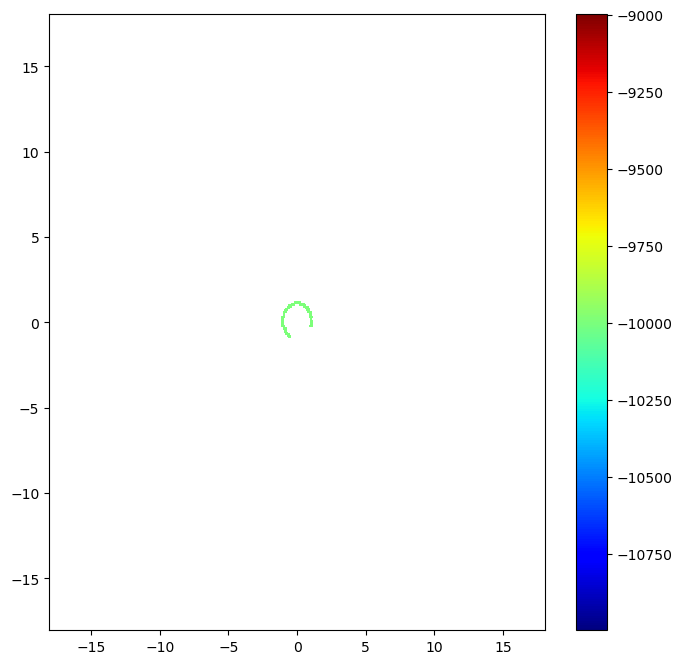

In [7]:
# plot
fig,ax = plt.subplots(figsize=(8,8))
plt.pcolormesh(qvp.X/1000,qvp.Y/1000,qvp.DBZ[0,10,:,:], cmap='jet')
plt.colorbar()